Prerequisites

Before running this notebook, the following tasks must be completed:

1. Download + preprocess the data by running `data/luo_2017_mouse.py
2. Train a MethylVI model by running `experiment_scripts/train_model.py` with the `luo_2017_mouse` dataset

In [1]:
from methyl_vi.model import MethylVI
import mudata
from collections import defaultdict
import scanpy as sc
from scvi import settings
import numpy as np
from utils import get_mm_ensembl_mappings
import diffxpy.api as de
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from scipy.stats import pearsonr, spearmanr, kendalltau
from scipy.stats import fisher_exact
import rpy2.robjects as ro
import rpy2.robjects.numpy2ri
from rpy2.robjects import globalenv
from sklearn.metrics import roc_auc_score
import matplotlib.patches as mpatches

rpy2.robjects.numpy2ri.activate()

/homes/gws/ewein/micromamba/envs/methyl-vi-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/homes/gws/ewein/micromamba/envs/methyl-vi-env/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/homes/gws/ewein/micromamba/envs/methyl-vi-env/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/homes/gws/ewein/micromamba/envs/methyl-vi-env/lib/python3.10/site-packages/docrep/decorators.py:43: SyntaxWarnin

In [2]:
biomart_dict = get_mm_ensembl_mappings()

In [3]:
n_features = "2500"

mdata = mudata.read_h5mu(
    f"/projects/leelab2/metVI/Luo2017_Mouse/data/gene_{n_features}_features.h5mu"
)

bulk_mdata = mudata.read_h5mu(
    f"/projects/leelab2/metVI/Mo_2015_MethylC-seq/data/gene_{n_features}_features.h5mu"
)

import pickle

modality = 'mCH'
methylVI_imputed = pickle.load(
    open(f"/projects/leelab2/metVI/results/Luo2017_Mouse/gene/{n_features}_features/methylVI/likelihood_betabinomial/dispersion_gene/latent_20/42/normalized_expression.pkl", "rb")
)[modality]

mdata['mCH'].layers['methylVI'] = methylVI_imputed
mdata['mCH'].layers['log_methylVI'] = np.log(mdata['mCH'].layers['methylVI'])

In [4]:
excitatory_subtypes = [
    "mL2/3",
    "mL4",
    "mL5-1",
    "mDL-1",
    "mDL-2",
    "mDL-3",
    "mIn-1",
    "mL6-1",
    "mL6-2",
    "mL5-2"
]

def get_neuron_type(x):
    if x in excitatory_subtypes:
        return "Excitatory"
    else:
        return "Inhibitory"

mdata.obs['Coarse_type'] = [get_neuron_type(x) for x in mdata.obs["mCG:Neuron type"]]

In [5]:
model = MethylVI.load(
    f"/projects/leelab2/metVI/results/Luo2017_Mouse/gene/{n_features}_features/methylVI/likelihood_betabinomial/dispersion_gene/latent_20/123/model.ckpt",
    adata=mdata
)

INFO     File                                                                                                      
         /projects/leelab2/metVI/results/Luo2017_Mouse/gene/2500_features/methylVI/likelihood_betabinomial/dispersi
         on_gene/latent_20/123/model.ckpt/model.pt already downloaded                                              


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [6]:
modality = 'mCH'

group1 = "Excitatory"
group2 = "Inhibitory"
adata = mdata[modality].copy()

raw_frac = adata.layers['mc'] / adata.layers['cov']

cell_rate_mean = np.nanmean(raw_frac, axis=1)
cell_rate_var = np.nanvar(raw_frac, axis=1)

cell_a = (1 - cell_rate_mean) * (cell_rate_mean ** 2) / cell_rate_var - cell_rate_mean
cell_b = cell_a * (1 / cell_rate_mean - 1)

post_frac = (adata.layers['mc'] + cell_a[:, None]) / (
            adata.layers['cov'] + cell_a[:, None] + cell_b[:, None])
prior_mean = cell_a / (cell_a + cell_b)
post_frac = post_frac / prior_mean[:, None]

adata.X = np.log(post_frac)

adata.obs['Coarse_type'] = [get_neuron_type(x) for x in adata.obs["Neuron type"]]

/tmp/ipykernel_1960531/1895925795.py:7: RuntimeWarning: invalid value encountered in divide
  raw_frac = adata.layers['mc'] / adata.layers['cov']


In [7]:
seed = 123
model = MethylVI.load(
    f"/projects/leelab2/metVI/results/Luo2017_Mouse/gene/{n_features}_features/methylVI/likelihood_betabinomial/dispersion_gene/latent_20/{seed}/model.ckpt",
    adata=mdata
)

results = model.differential_methylation(
    adata=mdata,
    modality=modality,
    groupby="Coarse_type",
    group1=group1,
    group2=group2,
    mode="vanilla",
    n_samples=5000
)

results.index = [biomart_dict[x.split(".")[0]] for x in results.index]
results = results.loc[results.index != ""]

INFO     File                                                                                                      
         /projects/leelab2/metVI/results/Luo2017_Mouse/gene/2500_features/methylVI/likelihood_betabinomial/dispersi
         on_gene/latent_20/123/model.ckpt/model.pt already downloaded                                              
DE...: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.19s/it]


/homes/gws/ewein/methylVI-github/methyl_vi/model/utils.py:52: RuntimeWarning: invalid value encountered in divide
  mean1 = np.asarray(np.nanmean(mc1 / cov1, axis=0)).ravel()
/homes/gws/ewein/methylVI-github/methyl_vi/model/utils.py:53: RuntimeWarning: invalid value encountered in divide
  mean2 = np.asarray(np.nanmean(mc2 / cov2, axis=0)).ravel()


In [8]:
import seaborn as sns
import matplotlib

/homes/gws/ewein/micromamba/envs/methyl-vi-env/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


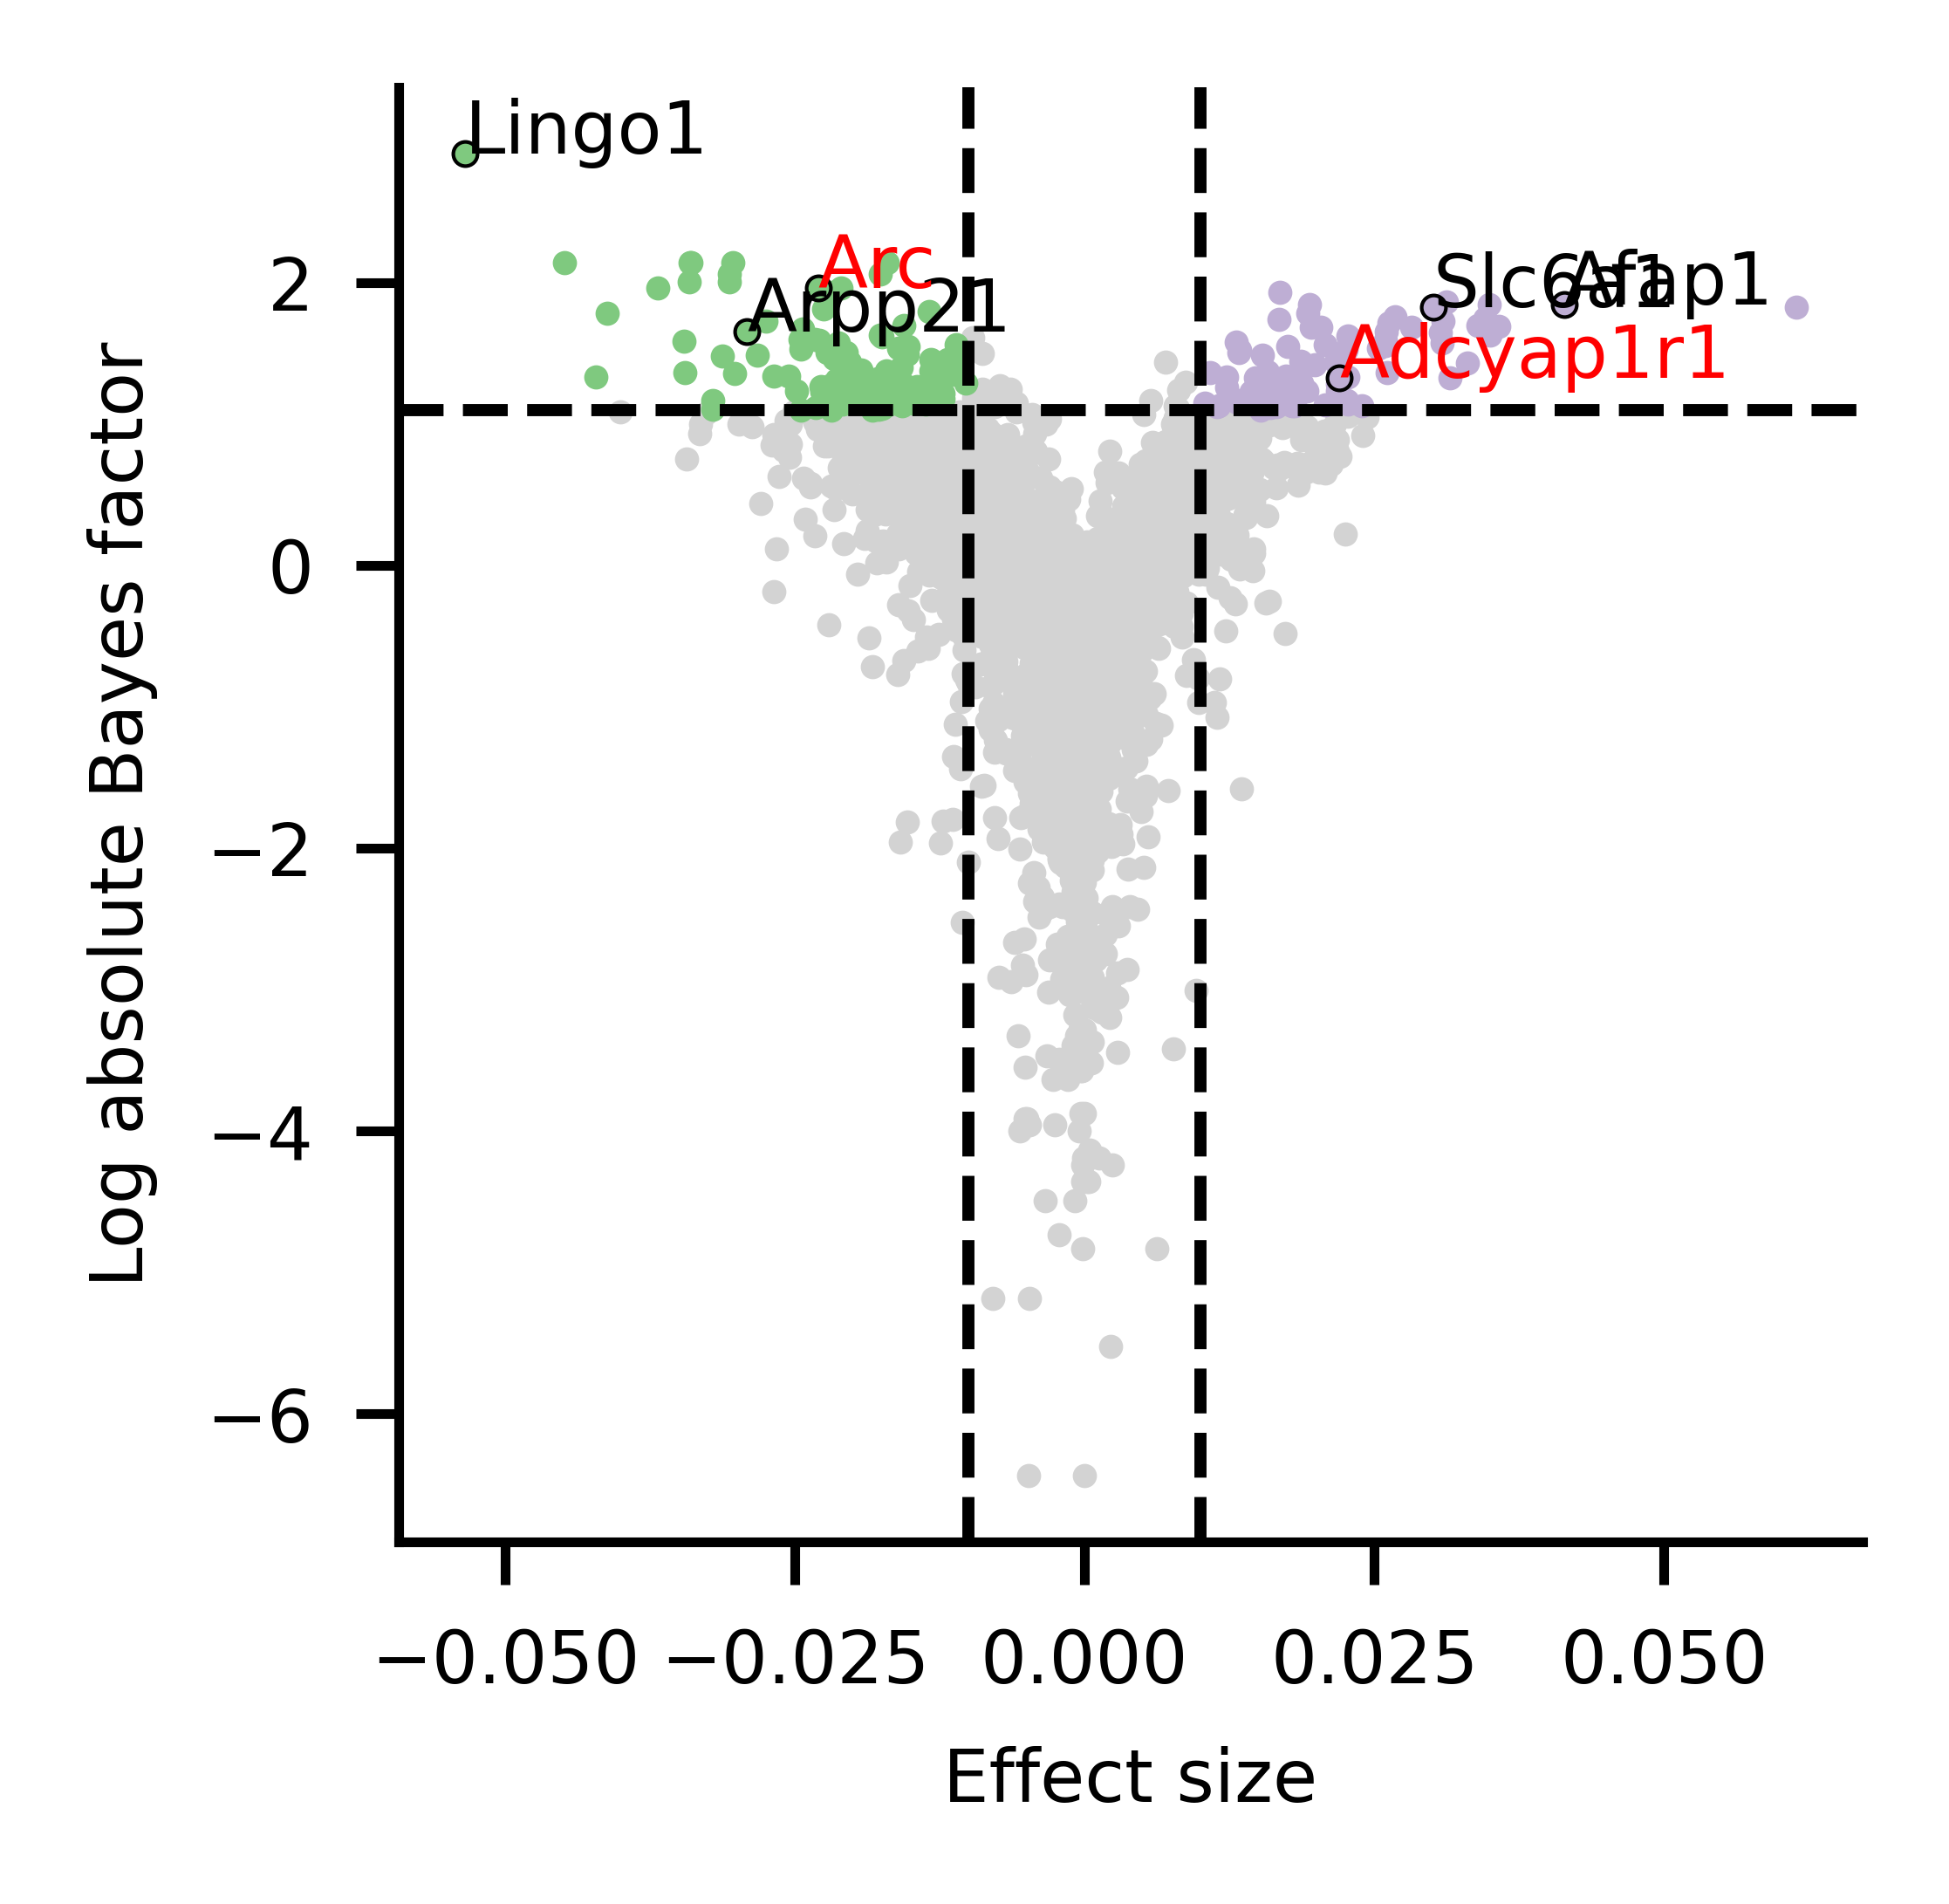

In [9]:
fontsize = 6
border_width = 0.5
width = 0.15
matplotlib.rcParams.update({'font.size': fontsize})
matplotlib.rcParams.update({'axes.titlesize': fontsize})
matplotlib.rcParams['font.family'] = 'sans-serif'

mm = 1/25.4
fig, ax = plt.subplots(figsize=(55*mm, 55*mm), dpi=1000)

bayes_factor_cutoff = 3
s = 1
min_emp_effect_size = 0.01

no_diff = results[
    (np.abs(results['bayes_factor']) < bayes_factor_cutoff) | 
    (np.abs(results['emp_effect']) < min_emp_effect_size)
]

exc_marker = results[
    (results['bayes_factor'] < (-1)*bayes_factor_cutoff) &
    (np.abs(results['emp_effect']) >= min_emp_effect_size)
]
inh_marker = results[
    (results['bayes_factor'] > bayes_factor_cutoff) &
    (np.abs(results['emp_effect']) >= min_emp_effect_size)
]

colors = {
    "no_diff": 'lightgrey',
    "exc_marker": sns.color_palette("Accent")[0],
    "inh_marker": sns.color_palette("Accent")[1]
}

ax.scatter(
    x=no_diff["emp_effect"],
    y=np.log(np.abs(no_diff['bayes_factor'])),
    s=s,
    color=colors['no_diff'],
    rasterized=True
)

ax.scatter(
    x=exc_marker["emp_effect"],
    y=np.log(np.abs(exc_marker['bayes_factor'])),
    s=s,
    color=colors['exc_marker'],
    rasterized=True
)

ax.scatter(
    x=inh_marker["emp_effect"],
    y=np.log(np.abs(inh_marker['bayes_factor'])),
    s=s,
    color=colors['inh_marker'],
    rasterized=True
)

known_excitatory_markers = [
    "Arpp21",   # Old
    'Lingo1',   # Old
]
new_excitatory_markers = [
    'Arc', # New
]

for gene in known_excitatory_markers + new_excitatory_markers:
    ax.scatter(
        x=results.loc[gene]['emp_effect'],
        y=np.log(np.abs(results.loc[gene]['bayes_factor'])),
        color=colors['exc_marker'],
        edgecolor='black',
        s=s+3,
        linewidths=0.3,
        rasterized=True
    )

    annotation_color = 'black' if gene in known_excitatory_markers else 'red'
    ax.annotate(
        text=gene,
        xy=(
            results.loc[gene]['emp_effect'], np.log(np.abs(results.loc[gene]['bayes_factor']))
        ),
        fontsize=6,
        color=annotation_color
    )

known_inhibitory_markers = [
    'Afap1',
    'Slc6a1', # Old
]

new_inhibitory_markers = [
    'Adcyap1r1',  # New
]

for gene in known_inhibitory_markers + new_inhibitory_markers:
    
    ax.scatter(
        x=results.loc[gene]['emp_effect'],
        y=np.log(np.abs(results.loc[gene]['bayes_factor'])),
        color=colors['inh_marker'],
        edgecolor='black',
        s=s+3,
        linewidths=0.3,
        rasterized=True
    )

    annotation_color = 'black' if gene in known_inhibitory_markers else 'red'
    weight = 'bold' if gene in new_inhibitory_markers else None
    ax.annotate(
        text=gene,
        xy=(
            results.loc[gene]['emp_effect'], np.log(np.abs(results.loc[gene]['bayes_factor']))
        ),
        fontsize=6,
        color=annotation_color,
        #weight=weight
    )

ax.set_xlabel("Effect size", fontsize=6)
ax.set_ylabel("Log absolute Bayes factor", fontsize=6)

ax.axhline(
    np.log(3),
    linestyle='--', 
    color='black',
    linewidth=1
)
ax.axvline(
    0.01,
    linestyle='--',
    color='black',
    linewidth=1
)
ax.axvline(
    -0.01,
    linestyle='--',
    color='black',
    linewidth=1
)

ax.set_xticks([-0.05, -0.025, 0, 0.025, 0.05])
ax.grid(False)

sns.despine()
plt.savefig("volcano.pdf", dpi=500)

In [10]:
luo_markers = pd.read_excel(
    "aan3351-table-s3.xlsx",
    header=1
)
luo_markers = luo_markers.set_index("Gene")

/homes/gws/ewein/micromamba/envs/methyl-vi-env/lib/python3.10/site-packages/openpyxl/worksheet/_read_only.py:81: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


In [11]:
mdata['mCH'].var["symbol"] = [biomart_dict[x.split(".")[0]] for x in mdata['mCH'].var.index]
mdata['mCH'].var.set_index("symbol", inplace=True)
mdata['mCH'].var_names_make_unique()
mdata['mCH'].obs['Coarse_type'] = [get_neuron_type(x) for x in mdata.obs["mCH:Neuron type"]]

In [12]:
known_pan_excitatory_markers_full = [
    # Fig S10A from Luo et al. 2017
    "Satb2",
    "Tyro3",
    "Arpp21",
    "Slc17a7",
    "Tbr1",
    "Camk2a",
    "Itpka",
    
    # Fig S10D from Luo et al. 2017
    "Mybph",
    "Foxp1",
    "Fhl2",
    "Abi2",
    "Slc8a2",
    "Sv2b",
    "Rasal1",
    "Ptprd",
    "Ltk",
    "Baiap2",
    "Lingo1",
    "Nrgn",
    "Arpp19",
    "Npas4",
    "Kcnh3"
]


known_pan_inhibitory_markers_full = [
    # Fig S10A from Luo et al. 2017
    "Erbb4",
    "Gad1",
    "Slc6a1"

    # Fig S10D from Luo et al. 2017
    "Ccne1",
    "Kcnab3",
    "Prkx",
    "Lpp",
    "Tbc1d9",
    "Dusp10",
    "Dvl3",
    "Kcnmb2",
    "Ubash3b",
    "Maf",
    "Dock11",
    "Lancl3",
    "Ank1"
]

In [13]:
total_markers = known_pan_excitatory_markers_full + known_pan_inhibitory_markers_full
total_markers = [x for x in total_markers if x in mdata['mCH'].var.index]

In [14]:
exc_markers_to_display = [x for x in exc_marker.index if not x.startswith("Gm")]
exc_markers_to_display = [x for x in exc_markers_to_display if not x.endswith("Rik")]

inh_markers_to_display = [x for x in inh_marker.index if not x.startswith("Gm")]
inh_markers_to_display = [x for x in inh_markers_to_display if not x.endswith("Rik")]

In [15]:
from random import sample

methylVI_differentially_methylated_genes = set(
    exc_marker.index
).union(set(inh_marker.index))

intersecting_genes = methylVI_differentially_methylated_genes.intersection(total_markers)
intersecting_exc_markers = methylVI_differentially_methylated_genes.intersection(known_pan_excitatory_markers_full)
intersecting_inh_markers = methylVI_differentially_methylated_genes.intersection(known_pan_inhibitory_markers_full)

forced_display_exc_markers = ["Arc", "Rap1gap2"]
new_exc_markers = set(exc_marker.index) - set(known_pan_excitatory_markers_full)
new_exc_markers = [x for x in new_exc_markers if not x.startswith("Gm")]
new_exc_markers = [x for x in new_exc_markers if not x.endswith("Rik")]
new_exc_markers = [x for x in new_exc_markers if x not in forced_display_exc_markers]
new_exc_markers = sample(new_exc_markers, len(intersecting_exc_markers) - len(forced_display_exc_markers))

forced_display_inh_markers = ["Adcyap1r1", "Gad2"]
new_inh_markers = set(inh_marker.index) - set(known_pan_inhibitory_markers_full)
new_inh_markers = [x for x in new_inh_markers if not x.startswith("Gm")]
new_inh_markers = [x for x in new_inh_markers if not x.endswith("Rik")]
new_inh_markers = [x for x in new_inh_markers if x not in forced_display_inh_markers]
new_inh_markers = sample(new_inh_markers, len(intersecting_inh_markers) - len(forced_display_inh_markers))

methylVI_enrichment = len(intersecting_genes)

In [16]:
sc.set_figure_params(figsize=(120*mm, 60*mm), fontsize=7)

adata = mdata['mCH'].copy()

target_cells = 500
cluster_key = "Coarse_type"

adatas = [adata[adata.obs[cluster_key] == clust] for clust in adata.obs[cluster_key].unique()]

for dat in adatas:
    if dat.n_obs > target_cells:
         sc.pp.subsample(dat, n_obs=target_cells)

adata_downsampled = adatas[0].concatenate(*adatas[1:])


/homes/gws/ewein/micromamba/envs/methyl-vi-env/lib/python3.10/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/homes/gws/ewein/micromamba/envs/methyl-vi-env/lib/python3.10/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


In [17]:
adata_downsampled.uns['Coarse_type_colors'] = [
    sns.color_palette("Accent")[0],
    sns.color_palette("Accent")[1]
]

In [18]:
list(forced_display_inh_markers) + list(new_inh_markers)

['Adcyap1r1', 'Gad2', 'Rcan3', 'Grip2', 'Idh2', 'Arhgef6']

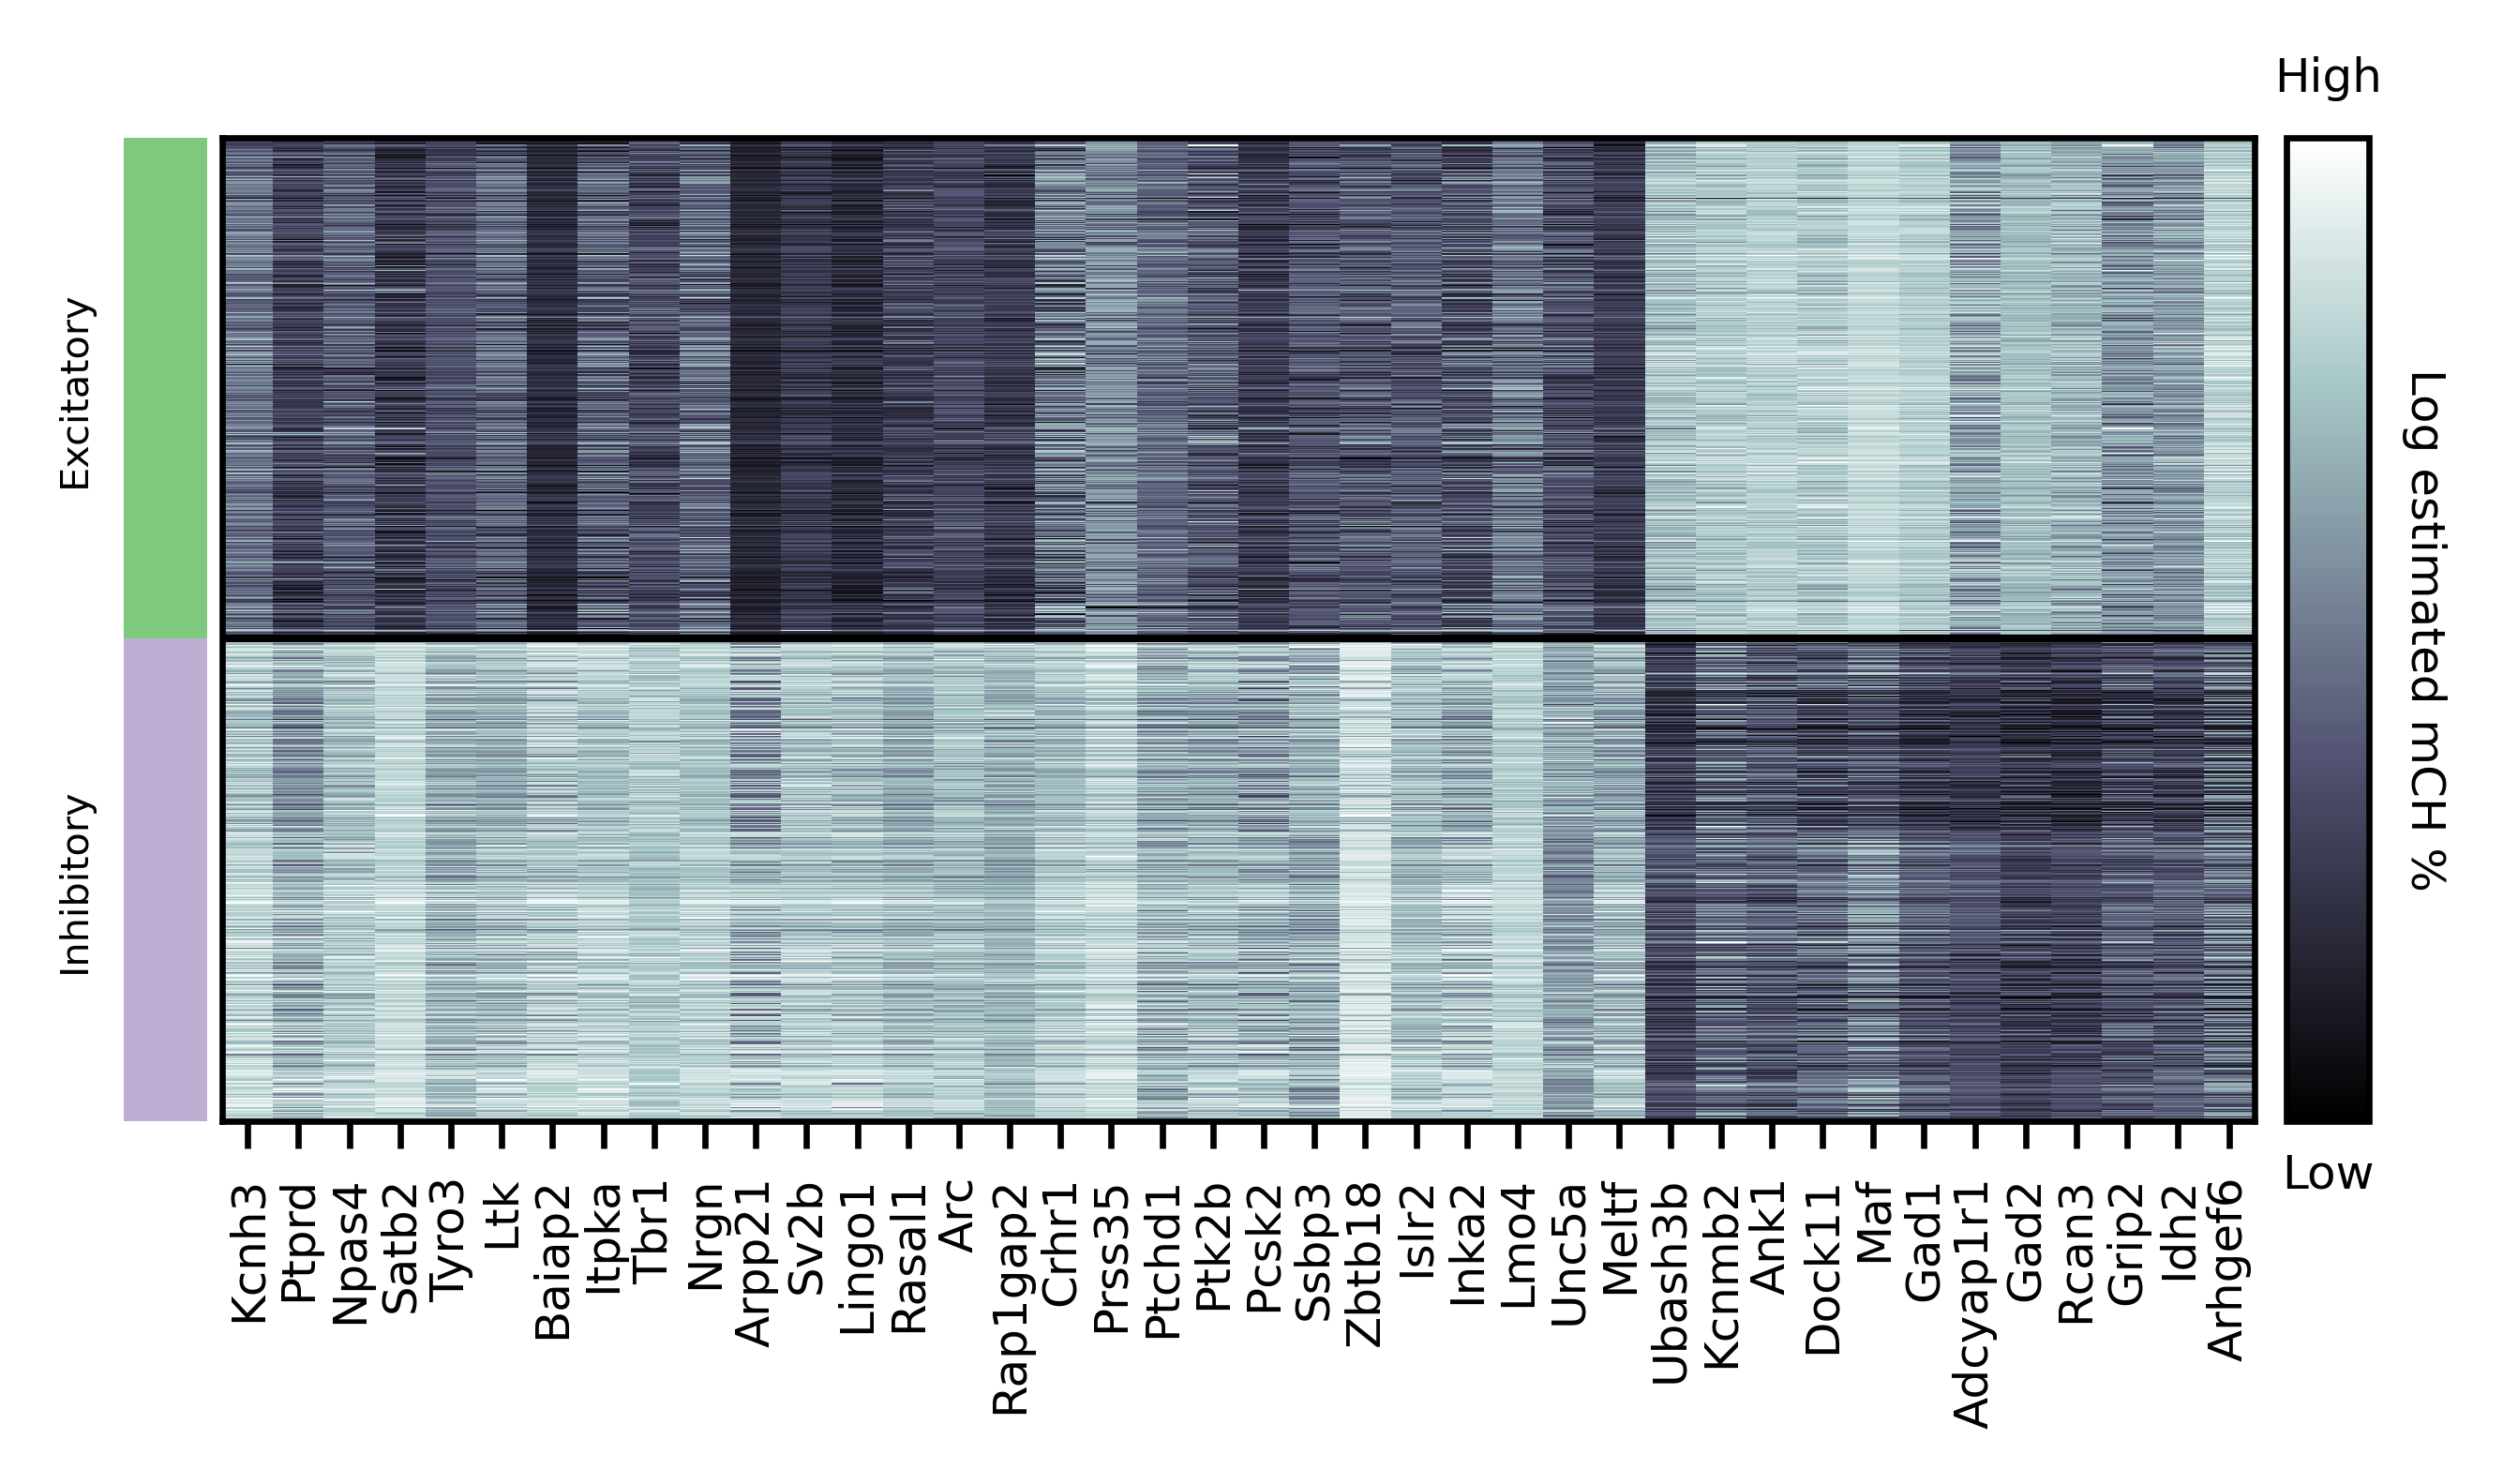

In [19]:
sc.set_figure_params(dpi=300, fontsize=6)

var_names = (
    list(intersecting_exc_markers) +
    list(forced_display_exc_markers) + 
    list(new_exc_markers) +
    list(intersecting_inh_markers) +
    list(forced_display_inh_markers) + 
    list(new_inh_markers)
)

ax = sc.pl.heatmap(
    adata_downsampled,
    var_names=var_names,
    groupby="Coarse_type",
    layer='log_methylVI',
    standard_scale='var',
    figsize=(130*mm, 60*mm),
    cmap='bone',
    show=False
)

ax['groupby_ax'].set_ylabel("")
ax['groupby_ax'].set_yticklabels(
    ax['groupby_ax'].get_yticklabels(), rotation=90, va='center', x=0.3
)

im = ax['heatmap_ax'].images
ax['heatmap_ax'].set_xticklabels(ax['heatmap_ax'].get_xticklabels(), fontsize=6)

# Assume colorbar plotted last
cb = im[-1].colorbar
cb.ax.set_title(label="High", fontsize=6) 
cb.ax.set_xlabel(xlabel="Low", fontsize=6) 
cb.ax.set_yticks([])
cb.ax.set_ylabel(
    "Log estimated mCH %",
    rotation=270,
    labelpad=10,
    fontsize=6
)

plt.savefig("heatmap.pdf")